<a href="https://colab.research.google.com/github/eftekhar-hossain/CUET_NLP-EACL_2021/blob/main/Hope_speech_detection_(EACL_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(42)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
### Pretrained Word Embeddings
pretrained_path = "/content/drive/MyDrive/Colab Notebooks/PreTrained Wordembeddings/"
dataset_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/Dataset/"
folder_path = "/content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CPU times: user 1.43 s, sys: 638 ms, total: 2.06 s
Wall time: 5.71 s


# English Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "english_hope_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "english_hope_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "english_hope_test.csv",delimiter='\t',header = None)

CPU times: user 48.8 ms, sys: 17.8 ms, total: 66.6 ms
Wall time: 3.54 s


In [ ]:
train_data = train_data.drop(columns=2)
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.drop(columns=2)
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-English':2})
valid_data['enc_label'] = valid_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-English':2})

In [ ]:
train_data

In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    20778
1     1962
2       22
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    2569
1     272
2       2
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (22762, 3)
Size of the validation data ==> (2843, 3)
Size of the Test data ==> (2846, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data = train_data.rename(columns={'label_Hope_speech':'Hope_speech','label_Non_hope_speech':'Non_hope_speech',
                                        'label_not-English':'not-English'})
train_data

,text,label,enc_label,Hope_speech,Non_hope_speech,not-English
0,these tiktoks radiate gay chaotic energy and i...,Non_hope_speech,0,0.0,1.0,0.0
1,@Champions Again He got killed for using false...,Non_hope_speech,0,0.0,1.0,0.0
2,It's not that all lives don't matter,Non_hope_speech,0,0.0,1.0,0.0
3,Is it really that difficult to understand? Bla...,Non_hope_speech,0,0.0,1.0,0.0
4,Whenever we say black isn't that racists? Why...,Non_hope_speech,0,0.0,1.0,0.0
...,...,...,...,...,...,...
22757,It's a load of bollocks every life matters sim...,Non_hope_speech,0,0.0,1.0,0.0
22758,no say it because all lives matter! deku would...,Non_hope_speech,0,0.0,1.0,0.0
22759,God says her life matters,Non_hope_speech,0,0.0,1.0,0.0
22760,This video is just shit. A bunch of whiny ass ...,Non_hope_speech,0,0.0,1.0,0.0


## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 these tiktoks radiate gay chaotic energy and i love it 
Cleaned Data:===
 these tiktoks radiate gay chaotic energy and i love it
Original Data:===
 @Champions Again He got killed for using false money 
Cleaned Data:===
 champions again he got killed for using false money
Original Data:===
 It's not that all lives don't matter 
Cleaned Data:===
 its not that all lives dont matter
Original Data:===
 Is it really that difficult to understand? Black lives matter and all lives matter are not mutually exclusive. They are both true as general statements. So are white lives matter and asian lives matter. Black lives matter in this context is simply the name of a movement against the strangely high rate of police violence on black people and the statement is referring to those who behave like and treat black people as if they dont matter. For example 
Cleaned Data:===
 is it really that difficult to understand black lives matter and all lives mat

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Hope_speech', 'Non_hope_speech','not-English']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
dataset_statistics(OH_X_train)


Class Name:--> Hope_speech 
Number of Words:49210
Number of Unique Words:4811
Maximum post length: 197
Average Words in texts: 25.081549439347604

Class Name:--> Non_hope_speech 
Number of Words:317854
Number of Unique Words:19740
Maximum post length: 191
Average Words in texts: 15.297622485321012

Class Name:--> not-English 
Number of Words:325
Number of Unique Words:239
Maximum post length: 47
Average Words in texts: 14.772727272727273


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Hope_speech', 'Non_hope_speech','not-English']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Hope_speech', 'Non_hope_speech','not-English']
  color = ['green','red','yellow']    
  bins = [1,20,40,60,80]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 17000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

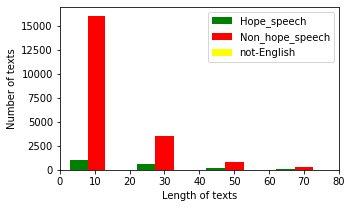

In [ ]:
comments_length_per_class(OH_X_train,'Training')

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Non_hope_speech    20778
Hope_speech         1962
not-English           22
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    2569
Hope_speech         272
not-English           2
Name: label, dtype: int64

In [ ]:
categories = ['Hope_speech','Non_hope_speech','not-English']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'albert-base-v2'
# 'roberta-base'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'xlnet-base-cased'
trans = text.Transformer(model_name,maxlen=100,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 45
	99percentile : 85


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 44
	99percentile : 83


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
# roberta -----> 2e-5

In [ ]:
learner.fit_onecycle(2e-5,4)  # 2e-5



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
1897/1897 [==============================] - 440s 221ms/step - loss: 0.3254 - accuracy: 0.8921 - val_loss: 0.2166 - val_accuracy: 0.9156
Epoch 2/4
1897/1897 [==============================] - 421s 220ms/step - loss: 0.1880 - accuracy: 0.9302 - val_loss: 0.1946 - val_accuracy: 0.9251
Epoch 3/4
1897/1897 [==============================] - 421s 220ms/step - loss: 0.1458 - accuracy: 0.9457 - val_loss: 0.2078 - val_accuracy: 0.9195
Epoch 4/4
1897/1897 [==============================] - 421s 220ms/step - loss: 0.0839 - accuracy: 0.9670 - val_loss: 0.2213 - val_accuracy: 0.9254


In [ ]:
learner.validate(class_names=categories)

                 precision    recall  f1-score   support

    Hope_speech       0.61      0.62      0.62       272
Non_hope_speech       0.96      0.96      0.96      2569
    not-English       0.00      0.00      0.00         2

       accuracy                           0.93      2843
      macro avg       0.52      0.53      0.53      2843
   weighted avg       0.93      0.93      0.93      2843



array([[ 169,  103,    0],
       [ 107, 2462,    0],
       [   0,    2,    0]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
predictor.save(folder_path+'Transformers_Models'+'/en_xlnet_predictor')

In [ ]:
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ml_xlm-r_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1


In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

In [ ]:
run.to_csv(folder_path +'english_xlnet.tsv',sep = '\t',index = False)

##Machine Learning

In [ ]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['text'])
vectorized_train_posts = vectorizer.transform(train_data['text'])
vectorized_valid_posts = vectorizer.transform(valid_data['text'])
vectorized_test_posts = vectorizer.transform(test_data['text'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  30528


In [ ]:
vectorized_valid_posts.shape

(2843, 30528)

In [ ]:
valid_data['enc_label'].value_counts()

0    2569
1     272
2       2
Name: enc_label, dtype: int64

In [ ]:
labels = ['Non_hope_speech','Hope_speech', 'not-English']
def actual_label(row):
    return labels[row]

###LR

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(class_weight='balanced',C =2)
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[2235  332    2]
 [  60  212    0]
 [   2    0    0]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2569
           1       0.39      0.78      0.52       272
           2       0.00      0.00      0.00         2

    accuracy                           0.86      2843
   macro avg       0.45      0.55      0.48      2843
weighted avg       0.92      0.86      0.88      2843

Accuracy :  0.8607105170594442
Precison :  0.8520447331456925
Recall :  0.8607105170594442
F1 :  0.8416231038255063


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,What do you mean by the word sniped?,Non_hope_speech
1,2,I love this video!! I’m bisexual and it’s just...,Hope_speech
2,3,ya the irony but then i don't want to come off...,Non_hope_speech
3,4,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech
4,5,@Blaster of Gasters,Non_hope_speech
...,...,...,...
2841,2842,+Ashrenneemakeup I think it's all a deliberate...,Non_hope_speech
2842,2843,Sheriff David Clarke. This guy is amazing.,Non_hope_speech
2843,2844,Abandorn Hope Situation,Non_hope_speech
2844,2845,Sheriff Clarke you are a person of such strong...,Non_hope_speech


In [ ]:
run.to_csv(folder_path +'english_lr.tsv',sep = '\t',index = False)

###SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(kernel='linear' ,C= 10,random_state=1234,class_weight='balanced')
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[2320  241    8]
 [  77  194    1]
 [   1    0    1]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2569
           1       0.45      0.71      0.55       272
           2       0.10      0.50      0.17         2

    accuracy                           0.88      2843
   macro avg       0.50      0.71      0.55      2843
weighted avg       0.92      0.88      0.90      2843

Accuracy :  0.8846289131199437
Precison :  0.8726104489300899
Recall :  0.8846289131199437
F1 :  0.8725017701857507


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,What do you mean by the word sniped?,Non_hope_speech
1,2,I love this video!! I’m bisexual and it’s just...,Hope_speech
2,3,ya the irony but then i don't want to come off...,Non_hope_speech
3,4,A PERSON'S CHARACTER MATTERS. PERIOD!!,Non_hope_speech
4,5,@Blaster of Gasters,Non_hope_speech
...,...,...,...
2841,2842,+Ashrenneemakeup I think it's all a deliberate...,Non_hope_speech
2842,2843,Sheriff David Clarke. This guy is amazing.,Non_hope_speech
2843,2844,Abandorn Hope Situation,Non_hope_speech
2844,2845,Sheriff Clarke you are a person of such strong...,Non_hope_speech


In [ ]:
run.to_csv(folder_path +'english_svm.tsv',sep = '\t',index = False)

###Ensemble Approach()

In [ ]:
LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced')
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)



In [ ]:
print_metrices(preds,valid_data['enc_label'])

[[2523   46    0]
 [ 194   78    0]
 [   2    0    0]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2569
           1       0.63      0.29      0.39       272
           2       0.00      0.00      0.00         2

    accuracy                           0.91      2843
   macro avg       0.52      0.42      0.45      2843
weighted avg       0.90      0.91      0.90      2843

Accuracy :  0.9148786493141048
Precison :  0.9517667792969009
Recall :  0.9148786493141048
F1 :  0.9297981657764133


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'english_voting.tsv',sep = '\t',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 1000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [ ]:
print(vocab_size)

20458


In [ ]:
max_len = 100
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

20457
Number of Training Sequences : (22762, 100)
Number of Validation Sequences : (2843, 100)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (2846, 100)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(3)}

In [ ]:
weight

{0: 0.36516186992652483, 1: 3.867142371729528, 2: 344.8787878787879}

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 100, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2045800   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 64)            41216     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3651      
Total params: 2,154,795
Trainable params: 2,154,795
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=15,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/15
570/570 [==============================] - 13s 18ms/step - loss: 1.7178 - accuracy: 0.3890 - val_loss: 1.6411 - val_accuracy: 0.0503

Epoch 00001: val_accuracy improved from -inf to 0.05030, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/BiLSTMModel.h5
Epoch 2/15
570/570 [==============================] - 10s 17ms/step - loss: 0.8324 - accuracy: 0.4058 - val_loss: 0.5610 - val_accuracy: 0.7628

Epoch 00002: val_accuracy improved from 0.05030 to 0.76279, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/BiLSTMModel.h5
Epoch 3/15
570/570 [==============================] - 10s 17ms/step - loss: 0.4860 - accuracy: 0.7205 - val_loss: 0.5596 - val_accuracy: 0.7718

Epoch 00003: val_accuracy improved from 0.76279 to 0.77180, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/BiLSTMModel.h5
Epoch 4/15
570/570 [===========

In [ ]:
# Load the saved model
model = load_model(folder_path+'BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)

print("F1-Score:",f1_score(valid_data['enc_label'],y_pred,average = 'weighted')*100)
print("Accuracy:",accuracy_score(valid_data['enc_label'],y_pred)*100)

F1-Score: 89.95109787894442
Accuracy: 89.51811466760464


In [ ]:
from sklearn.metrics import classification_report

#Show precision and recall per genre
print(classification_report(valid_data['enc_label'], y_pred, target_names=['Non_hope_speech','Hope_speech','not-English']))

                 precision    recall  f1-score   support

Non_hope_speech       0.95      0.93      0.94      2569
    Hope_speech       0.47      0.56      0.51       272
    not-English       0.00      0.00      0.00         2

       accuracy                           0.90      2843
      macro avg       0.47      0.50      0.48      2843
   weighted avg       0.90      0.90      0.90      2843



In [ ]:
confusion_matrix(y_true=valid_data['enc_label'], y_pred=y_pred)

array([[2392,  174,    3],
       [ 119,  153,    0],
       [   2,    0,    0]])

### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'english_cnn+bilstm.tsv',sep = '\t',index = False)

##Pretrained Embedding

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'))

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

###Model Defination

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_en-BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 200,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          6137400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 19, 400)           526400    
_________________________________________________________________
flatten_4 (Flatten)          (None, 7600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 22803     
Total params: 6,878,731
Trainable params: 741,331
Non-trainable params: 6,137,400
______________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=50,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/50
570/570 [==============================] - 10s 12ms/step - loss: 1.5966 - accuracy: 0.5262 - val_loss: 0.6540 - val_accuracy: 0.8078

Epoch 00001: val_accuracy improved from -inf to 0.80782, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/prt_en-BiLSTMModel.h5
Epoch 2/50
570/570 [==============================] - 6s 10ms/step - loss: 1.3839 - accuracy: 0.5100 - val_loss: 0.7115 - val_accuracy: 0.7424

Epoch 00002: val_accuracy did not improve from 0.80782
Epoch 3/50
570/570 [==============================] - 6s 10ms/step - loss: 0.9799 - accuracy: 0.4783 - val_loss: 0.8549 - val_accuracy: 0.5322

Epoch 00003: val_accuracy did not improve from 0.80782
Epoch 4/50
570/570 [==============================] - 6s 10ms/step - loss: 0.6723 - accuracy: 0.6041 - val_loss: 0.8454 - val_accuracy: 0.6503

Epoch 00004: val_accuracy did not improve from 0.80782
Epoch 5/50
570/570 [==============================] - 6s 10ms/step - loss: 

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_en-BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(y_pred,valid_data['enc_label'])


[[2446  116    7]
 [ 150  121    1]
 [   1    0    1]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2569
           1       0.51      0.44      0.48       272
           2       0.11      0.50      0.18         2

    accuracy                           0.90      2843
   macro avg       0.52      0.63      0.53      2843
weighted avg       0.90      0.90      0.90      2843

Accuracy :  0.9032711924023918
Precison :  0.9084029361954916
Recall :  0.9032711924023918
F1 :  0.9052316498257138


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'english_cnn+bilstm+fasttext.tsv',sep = '\t',index = False)

# Malaylam Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "malayalam_hope_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "malayalam_hope_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "malayalam_hope_test.csv",delimiter='\t',header = None)

CPU times: user 38.8 ms, sys: 15.2 ms, total: 54 ms
Wall time: 2.82 s


In [ ]:
test_data

In [ ]:
train_data = train_data.drop(columns=2)
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.drop(columns=2)
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-malayalam':2})
valid_data['enc_label'] = valid_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-malayalam':2})

In [ ]:
train_data

In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    6205
1    1668
2     691
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    784
1    190
2     96
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (8564, 3)
Size of the validation data ==> (1070, 3)
Size of the Test data ==> (1071, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data = train_data.rename(columns={'label_Hope_speech':'Hope_speech','label_Non_hope_speech':'Non_hope_speech',
                                        'label_not-malayalam':'not-malayalam'})
train_data

## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 @arya s nair may be athile karthikayude charctr bisexual ayirikkum 
Cleaned Data:===
 arya s nair may be athile karthikayude charctr bisexual ayirikkum
Original Data:===
 വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്ലോ ഇനി വാങ്ങാതിരിക്കാൻ ശ്രദ്ധിക്കുക Jai India 
Cleaned Data:===
 വാങ്ങിയത് എന്ത് കുന്തം ആയാലും കളയാൻ പറ്റില്ലല്ലോ ഇനി വാങ്ങാതിരിക്കാൻ ശ്രദ്ധിക്കുക jai india
Original Data:===
 മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue  ആയിരുന്നു...അത് ഈ വിഷയവുമായി കമ്പയർ ചെയ്യാൻ പറ്റില്ല.താങ്കൾ പറഞ്ഞത് തെറ്റാണ്.സാധാരണ വേഷം അണിഞ്ഞാൽ പോലും നോക്കി കൊല്ലുന്ന നാട്ടുകാർ ഉള്ളയിടത്തു ഫെമിനിസത്തിന് വസ്ത്രത്തെക്കുറിച്ചു  സംസാരിക്കേണ്ടി തന്നെ വരും... 
Cleaned Data:===
 മാറുമറയ്ക്കാൻ നടത്തിയ സമരം ഒരു previlege issue ആയിരുന്നുഅത് ഈ വിഷയവുമായി കമ്പയർ ചെയ്യാൻ പറ്റില്ലതാങ്കൾ പറഞ്ഞത് തെറ്റാണ്സാധാരണ വേഷം അണിഞ്ഞാൽ പോലും നോക്കി കൊല്ലുന്ന നാട്ടുകാർ ഉള്ളയിടത്തു ഫെമിനിസത്തിന് വസ്ത്രത്തെക്കുറിച്ചു സംസാരിക്കേണ്ടി തന്നെ വരും
Original Data:===
 ഇഷാനെ കൂടുതല് കെട്

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Hope_speech', 'Non_hope_speech','not-malayalam']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
train_data

In [ ]:
dataset_statistics(train_data)


Class Name:--> Hope_speech 
Number of Words:25144
Number of Unique Words:11827
Maximum post length: 96
Average Words in texts: 15.074340527577938

Class Name:--> Non_hope_speech 
Number of Words:60313
Number of Unique Words:24607
Maximum post length: 95
Average Words in texts: 9.72006446414182

Class Name:--> not-malayalam 
Number of Words:2644
Number of Unique Words:1040
Maximum post length: 35
Average Words in texts: 3.8263386396526773


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Hope_speech', 'Non_hope_speech','not-malayalam']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Hope_speech', 'Non_hope_speech','not-malayalam']
  color = ['green','red','yellow']    
  bins = [1,20,40,60,80]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 17000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

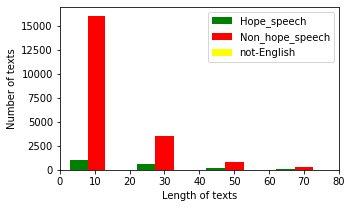

In [ ]:
comments_length_per_class(OH_X_train,'Training')

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Non_hope_speech    6205
Hope_speech        1668
not-malayalam       691
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    784
Hope_speech        190
not-malayalam       96
Name: label, dtype: int64

In [ ]:
categories = ['Hope_speech','Non_hope_speech','not-malayalam']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'ai4bharat/indic-bert'
# 'albert-base-v2'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'xlnet-base-cased'
trans = text.Transformer(model_name,maxlen=80,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: ml
train sequence lengths:
	mean : 10
	95percentile : 31
	99percentile : 54


Is Multi-Label? False
preprocessing test...
language: ml
test sequence lengths:
	mean : 10
	95percentile : 30
	99percentile : 51


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

weight = {i : class_weights[i] for i in range(3)}
weight

{0: 1.7114308553157473, 1: 0.4600590921300027, 2: 4.131210805595755}

In [ ]:
learner.fit_onecycle(2e-5,4)  # 2e-5



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
714/714 [==============================] - 158s 187ms/step - loss: 0.7005 - accuracy: 0.7265 - val_loss: 0.5173 - val_accuracy: 0.7981
Epoch 2/4
714/714 [==============================] - 133s 183ms/step - loss: 0.5213 - accuracy: 0.7803 - val_loss: 0.4627 - val_accuracy: 0.8140
Epoch 3/4
714/714 [==============================] - 132s 182ms/step - loss: 0.4574 - accuracy: 0.7991 - val_loss: 0.4892 - val_accuracy: 0.8056
Epoch 4/4
714/714 [==============================] - 133s 183ms/step - loss: 0.3801 - accuracy: 0.8353 - val_loss: 0.5028 - val_accuracy: 0.8075


In [ ]:
learner.validate(class_names=categories)

                 precision    recall  f1-score   support

    Hope_speech       0.56      0.39      0.46       190
Non_hope_speech       0.84      0.92      0.88       784
  not-malayalam       0.84      0.72      0.78        96

       accuracy                           0.81      1070
      macro avg       0.75      0.68      0.70      1070
   weighted avg       0.79      0.81      0.80      1070



array([[ 74, 114,   2],
       [ 52, 721,  11],
       [  6,  21,  69]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
predictor.save(folder_path+'Transformers_Models'+'/ml_xlnet_predictor')


In [ ]:
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ml_xlm-r_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

In [ ]:
run.to_csv(folder_path +'malayalam_xlnet.tsv',sep = '\t',index = False)

##Machine Learning

In [ ]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['text'])
vectorized_train_posts = vectorizer.transform(train_data['text'])
vectorized_valid_posts = vectorizer.transform(valid_data['text'])
vectorized_test_posts = vectorizer.transform(test_data['text'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  35631


In [ ]:
vectorized_valid_posts.shape

(2843, 20798)

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    2569
Hope_speech         272
not-English           2
Name: label, dtype: int64

In [ ]:
labels = ['Non_hope_speech','Hope_speech', 'not-malayalam']
def actual_label(row):
    return labels[row]

### Logistic Regression

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(class_weight='balanced',C =1)
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[647  98  39]
 [ 58 118  14]
 [ 20   3  73]]
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       784
           1       0.54      0.62      0.58       190
           2       0.58      0.76      0.66        96

    accuracy                           0.78      1070
   macro avg       0.67      0.74      0.70      1070
weighted avg       0.80      0.78      0.79      1070

Accuracy :  0.7831775700934579
Precison :  0.7758252105564312
Recall :  0.7831775700934579
F1 :  0.7765745118472753


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അതെ അണപൊട്ടി ഒഴുകുകയാണ്,Non_hope_speech
1,2,കെവിൻ avde pettupoyi🤣🤣🤣,Non_hope_speech
2,3,@my voice ullup illa daaa tayoli ath kond alle...,Non_hope_speech
3,4,@Albin Baiju,Non_hope_speech
4,5,I respect you..,not-malayalam
...,...,...,...
1066,1067,ചേട്ടാ അതിന് ഇവിടെ ആരാണ് ഇന്ത്യൻ മൊബൈൽ റിവ്യൂ ...,Non_hope_speech
1067,1068,@surya ishaan,not-malayalam
1068,1069,ഏതാണ് ആ മൂലയിൽ ഇരിക്കുന്ന അപ്പൂപ്പൻ,Non_hope_speech
1069,1070,ഏതാ ആ ചൊമന്ന ടി ഷർട്ടിന് മേൽ കോട്ടിട്ട വവ്വാൽ...,Non_hope_speech


In [ ]:
run.to_csv(folder_path +'malayalam_lr.tsv',sep = '\t',index = False)

### SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(kernel='linear' ,random_state=1234,class_weight='balanced')
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[649 103  32]
 [ 66 108  16]
 [ 24   4  68]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       784
           1       0.50      0.57      0.53       190
           2       0.59      0.71      0.64        96

    accuracy                           0.77      1070
   macro avg       0.66      0.70      0.68      1070
weighted avg       0.79      0.77      0.78      1070

Accuracy :  0.7710280373831776
Precison :  0.7627345023105159
Recall :  0.7710280373831776
F1 :  0.765332516376666


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അതെ അണപൊട്ടി ഒഴുകുകയാണ്,Non_hope_speech
1,2,കെവിൻ avde pettupoyi🤣🤣🤣,Non_hope_speech
2,3,@my voice ullup illa daaa tayoli ath kond alle...,Non_hope_speech
3,4,@Albin Baiju,Non_hope_speech
4,5,I respect you..,not-malayalam
...,...,...,...
1066,1067,ചേട്ടാ അതിന് ഇവിടെ ആരാണ് ഇന്ത്യൻ മൊബൈൽ റിവ്യൂ ...,Non_hope_speech
1067,1068,@surya ishaan,not-malayalam
1068,1069,ഏതാണ് ആ മൂലയിൽ ഇരിക്കുന്ന അപ്പൂപ്പൻ,Non_hope_speech
1069,1070,ഏതാ ആ ചൊമന്ന ടി ഷർട്ടിന് മേൽ കോട്ടിട്ട വവ്വാൽ...,Non_hope_speech


In [ ]:
run['label'].value_counts()

Non_hope_speech    732
Hope_speech        225
not-malayalam      114
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'malayalam_svm.tsv',sep = '\t',index = False)

### Ensemble Appraoch (Majority Voting)

In [ ]:

LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced')
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(C = 5,class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'], preds)


[[742 122  29]
 [ 21  60   3]
 [ 21   8  64]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       893
           1       0.32      0.71      0.44        84
           2       0.67      0.69      0.68        93

    accuracy                           0.81      1070
   macro avg       0.64      0.74      0.67      1070
weighted avg       0.87      0.81      0.83      1070

Accuracy :  0.8093457943925234
Precison :  0.7973924606190232
Recall :  0.8093457943925234
F1 :  0.7869156674129253


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,അതെ അണപൊട്ടി ഒഴുകുകയാണ്,Non_hope_speech
1,2,കെവിൻ avde pettupoyi🤣🤣🤣,Non_hope_speech
2,3,@my voice ullup illa daaa tayoli ath kond alle...,Non_hope_speech
3,4,@Albin Baiju,Non_hope_speech
4,5,I respect you..,not-malayalam
...,...,...,...
1066,1067,ചേട്ടാ അതിന് ഇവിടെ ആരാണ് ഇന്ത്യൻ മൊബൈൽ റിവ്യൂ ...,Non_hope_speech
1067,1068,@surya ishaan,not-malayalam
1068,1069,ഏതാണ് ആ മൂലയിൽ ഇരിക്കുന്ന അപ്പൂപ്പൻ,Non_hope_speech
1069,1070,ഏതാ ആ ചൊമന്ന ടി ഷർട്ടിന് മേൽ കോട്ടിട്ട വവ്വാൽ...,Non_hope_speech


In [ ]:
run.to_csv(folder_path +'malayalam_voting.tsv',sep = '\t',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

32113


In [ ]:
max_len = 100
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

32112
Number of Training Sequences : (8564, 100)
Number of Validation Sequences : (1070, 100)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (1071, 100)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(3)}

In [ ]:
weight

{0: 0.4600590921300027, 1: 1.7114308553157473, 2: 4.131210805595755}

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"ml_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 100, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 64)           34048     
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 19203     
Total params: 1,053,251
Trainable params: 1,053,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=15,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/15
215/215 [==============================] - 6s 18ms/step - loss: 0.9236 - accuracy: 0.4016 - val_loss: 0.5601 - val_accuracy: 0.7881

Epoch 00001: val_accuracy improved from -inf to 0.78809, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/ml_BiLSTMModel.h5
Epoch 2/15
215/215 [==============================] - 3s 15ms/step - loss: 0.3830 - accuracy: 0.8074 - val_loss: 0.6073 - val_accuracy: 0.7437

Epoch 00002: val_accuracy did not improve from 0.78809
Epoch 3/15
215/215 [==============================] - 3s 15ms/step - loss: 0.1565 - accuracy: 0.9346 - val_loss: 0.7306 - val_accuracy: 0.7402

Epoch 00003: val_accuracy did not improve from 0.78809
Epoch 4/15
215/215 [==============================] - 3s 15ms/step - loss: 0.0928 - accuracy: 0.9620 - val_loss: 0.8218 - val_accuracy: 0.7770

Epoch 00004: val_accuracy did not improve from 0.78809
Epoch 5/15
215/215 [==============================] - 3s 15ms/step - loss: 0.060

In [ ]:
# Load the saved model
model = load_model(folder_path+'ml_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[698 108  13]
 [ 27  70   0]
 [ 59  12  83]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       819
           1       0.37      0.72      0.49        97
           2       0.86      0.54      0.66       154

    accuracy                           0.80      1070
   macro avg       0.71      0.70      0.67      1070
weighted avg       0.84      0.80      0.81      1070

Accuracy :  0.7953271028037383
Precison :  0.8009575719374351
Recall :  0.7953271028037383
F1 :  0.7842866842586721


### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'malayalam_cnn+bilstm.tsv',sep = '\t',index = False)

##Pretrained Word Embedding (Fasttext)

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ml.300.vec.gz'))

In [ ]:
tokenizer = Tokenizer(num_words = 30000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index )+1

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 100
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

32112
Number of Training Sequences : (8564, 100)
Number of Validation Sequences : (1070, 100)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (1071, 100)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(3)}

#### Model Defination

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          9633900   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 19, 256)           263168    
_________________________________________________________________
flatten_12 (Flatten)         (None, 4864)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 14595     
Total params: 10,103,791
Trainable params: 469,891
Non-trainable params: 9,633,900
____________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=25,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/25
215/215 [==============================] - 5s 11ms/step - loss: 0.7971 - accuracy: 0.5380 - val_loss: 0.8328 - val_accuracy: 0.5470

Epoch 00001: val_accuracy improved from -inf to 0.54699, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/prt_BiLSTMModel.h5
Epoch 2/25
215/215 [==============================] - 2s 8ms/step - loss: 0.5291 - accuracy: 0.6920 - val_loss: 0.5700 - val_accuracy: 0.7601

Epoch 00002: val_accuracy improved from 0.54699 to 0.76007, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/prt_BiLSTMModel.h5
Epoch 3/25
215/215 [==============================] - 2s 7ms/step - loss: 0.4509 - accuracy: 0.7544 - val_loss: 0.6219 - val_accuracy: 0.7262

Epoch 00003: val_accuracy did not improve from 0.76007
Epoch 4/25
215/215 [==============================] - 2s 7ms/step - loss: 0.3883 - accuracy: 0.7653 - val_loss: 0.6683 - val_accuracy: 0.7034

Epoch 000

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[660  99  16]
 [ 63  79   6]
 [ 61  12  74]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       775
           1       0.42      0.53      0.47       148
           2       0.77      0.50      0.61       147

    accuracy                           0.76      1070
   macro avg       0.68      0.63      0.64      1070
weighted avg       0.77      0.76      0.76      1070

Accuracy :  0.7598130841121495
Precison :  0.7639345473459777
Recall :  0.7598130841121495
F1 :  0.7580334939734004


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 


In [ ]:
run.to_csv(folder_path +'malayalam_cnn+bilstm+fasttext.tsv',sep = '\t',index = False)

# Tamil Dataset 

In [ ]:
%%time
train_data = pd.read_csv(dataset_path + "tamil_hope_first_train.csv",delimiter='\t',header = None)
valid_data = pd.read_csv(dataset_path + "tamil_hope_first_dev.csv",delimiter='\t',header = None)
test_data = pd.read_csv(dataset_path + "tamil_hope_test.csv",delimiter='\t',header = None)

CPU times: user 39.6 ms, sys: 3.9 ms, total: 43.5 ms
Wall time: 66.8 ms


In [ ]:
test_data

In [ ]:
train_data = train_data.drop(columns=2)
train_data = train_data.rename(columns={0:'text',1:'label'})
valid_data = valid_data.drop(columns=2)
valid_data = valid_data.rename(columns={0:'text',1:'label'})
test_data = test_data.rename(columns={0:'text'})

In [ ]:
train_data['enc_label'] = train_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-Tamil':2})
valid_data['enc_label'] = valid_data['label'].replace({'Non_hope_speech':0, 'Hope_speech':1,'not-Tamil':2})

In [ ]:
train_data

In [ ]:
train_data['text'].tolist()

In [ ]:
train_data['enc_label'].value_counts()

0    7872
1    6327
2    1961
Name: enc_label, dtype: int64

In [ ]:
valid_data['enc_label'].value_counts()

0    998
1    757
2    263
Name: enc_label, dtype: int64

In [ ]:
print("Size of the training data ==> ", train_data.shape)
print("Size of the validation data ==>", valid_data.shape)
print("Size of the Test data ==>", test_data.shape)

Size of the training data ==>  (16160, 3)
Size of the validation data ==> (2018, 3)
Size of the Test data ==> (2020, 1)


## One Hot Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder=OneHotEncoder(sparse=False)

encoded_labels = pd.DataFrame (encoder.fit_transform(train_data[['label']]))

encoded_labels .columns = encoder.get_feature_names(['label'])

train_data= pd.concat([train_data, encoded_labels ], axis=1)

In [ ]:
train_data = train_data.rename(columns={'label_Hope_speech':'Hope_speech','label_Non_hope_speech':'Non_hope_speech',
                                        'label_not-Tamil':'not-Tamil'})
train_data

## Cleaning

In [ ]:
'''
Text Cleaning
'''
def text_cleaning(row):
  # to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  post = post.replace('—', ' ')
  # to remove accented characters
  new_text = unicodedata.normalize('NFKD', post).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  # to remove special characters and numbers
  # define the pattern to keep
  #pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
  #text = re.sub(pat, '', new_text)
  #to remove punctuation
  text = ''.join([c for c in text if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  # check in lowercase 
  #t = [token for token in tokens if token.lower() not in stopword_list]
  #text = ' '.join(t) 
  # Stemming
  #t = [stemming.stem(token) for token in tokens ]
  #text = ' '.join(t) 

  return text



In [ ]:
#removing URLs and Punctuations
#train_data['cleaned'] = train_data['tweet'].apply(remove_url)
#Removing punctuations
train_data['cleaned'] = train_data['text'].apply(text_cleaning)
valid_data['cleaned'] = valid_data['text'].apply(text_cleaning)
test_data['cleaned'] = test_data['text'].apply(text_cleaning)


## Data samples after cleaning
print("Data samples after cleaning:\n")
for i in range(10):
  print("Original Data:===\n",train_data.text[i],"\nCleaned Data:===\n",train_data.cleaned[i],)

Data samples after cleaning:

Original Data:===
 Realme india product 
Cleaned Data:===
 realme india product
Original Data:===
 I also don't have tiktok hello and allnBut I'm using xiaomi 
Cleaned Data:===
 i also dont have tiktok hello and allnbut im using xiaomi
Original Data:===
 Thalaivare..neengale inum one plus mobile vachurukinga...adha udachurunga 
Cleaned Data:===
 thalaivareneengale inum one plus mobile vachurukingaadha udachurunga
Original Data:===
 Annee varanda thondai.. corona virus affect pannum.. neenga pathukonga. Pause koduth pasuga anne. Thondaya varanda vidadhinga 
Cleaned Data:===
 annee varanda thondai corona virus affect pannum neenga pathukonga pause koduth pasuga anne thondaya varanda vidadhinga
Original Data:===
 5views but 18likes 
Cleaned Data:===
 5views but 18likes
Original Data:===
 China phone vakathiga inu evanga ellam tiktok la video poduravagal nChina  Phone vendam but China apps maittum use pannuvaga 
Cleaned Data:===
 china phone vakathiga inu evan

In [ ]:
valid_data['cleaned'].shape

(2843,)

## Data Statistics

In [ ]:
def char_length(row):
    return len(row.split())

In [ ]:
lables = ['Hope_speech', 'Non_hope_speech','not-Tamil']

# Count number of unique words in each set
def dataset_statistics(dataset):
  for l in lables:
    word_list = [word.strip() for t in list(dataset[dataset[l]==1.0].cleaned) for word in t.strip().split()]
    print(f"\nClass Name:--> {l} ") 
    print("Number of Words:{}".format(len(word_list))) 
    print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
    print("Maximum post length: {}".format(max(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    print("Average Words in texts: {}".format(np.mean(dataset[dataset[l]==1.0].cleaned.apply(char_length))))
    

In [ ]:
train_data

In [ ]:
dataset_statistics(train_data)


Class Name:--> Hope_speech 
Number of Words:56000
Number of Unique Words:17274
Maximum post length: 193
Average Words in texts: 8.850956219377272

Class Name:--> Non_hope_speech 
Number of Words:76302
Number of Unique Words:23977
Maximum post length: 176
Average Words in texts: 9.692835365853659

Class Name:--> not-Tamil 
Number of Words:7309
Number of Unique Words:2093
Maximum post length: 48
Average Words in texts: 3.727180010198878


## Tweets length per class

In [ ]:
def comments_length_per_class(dataset,set_name):
  label = dataset[['Hope_speech', 'Non_hope_speech','not-Tamil']]
  label = label.values
  comment = dataset['cleaned']
  comment = comment.values
  y = np.zeros(label.shape)
  for ix in range(comment.shape[0]):
      l = len(comment[ix].split())
      if label[ix][0] :
          y[ix][0] = l
      if label[ix][1] :
          y[ix][1] = l
  #color = ['red','green','blue','yellow','chartreuse'] 
  labelsplt = ['Hope_speech', 'Non_hope_speech','not-Tamil']
  color = ['green','red','yellow']    
  bins = [1,20,40,60,80]   
  plt.figure(figsize=(5,3)) 
  #plt.title ('Tweets Length Distribution Per Class')
  plt.hist(y,bins = bins,label = labelsplt,color = color)
  plt.axis([0, 80, 0, 17000])
  plt.xlabel('Length of texts')
  plt.ylabel('Number of texts') 
  plt.legend()
  #plt.savefig(path+'real-fake_no_title.png',dpi = 600,bbox_inches ='tight')
  #plt.grid(True)
  plt.show()

##Ktrain -BERT

1. [Text Classification Using Transformers](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb)

2. [Related Article](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)

3. [Ktrain](https://github.com/amaiya/ktrain)

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import ktrain
from ktrain import text

In [ ]:
train_data['label'].value_counts()

Non_hope_speech    7872
Hope_speech        6327
not-Tamil          1961
Name: label, dtype: int64

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    998
Hope_speech        757
not-Tamil          263
Name: label, dtype: int64

In [ ]:
categories = ['Hope_speech','Non_hope_speech','not-Tamil']

In [ ]:
X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_valid = valid_data['text'].tolist()
y_valid = valid_data['label'].tolist()

X_test = test_data['text'].tolist()
#y_test = test_data['label'].tolist()

In [ ]:
# 'bert-base-uncased'
# 'bert-base-multilingual-cased'
# 'distilbert-base-uncased'
# 'ai4bharat/indic-bert'
# 'albert-base-v2'
# 'xlm-roberta-base'
# 'xlnet-base-cased'


In [ ]:
model_name = 'ai4bharat/indic-bert'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

In [ ]:
train = trans.preprocess_train(X_train,y_train)
valid = trans.preprocess_test(X_valid,y_valid)
#test = trans.preprocess_test(X_test,y_test)


preprocessing train...
language: ta
train sequence lengths:
	mean : 9
	95percentile : 23
	99percentile : 46


Is Multi-Label? False
preprocessing test...
language: ta
test sequence lengths:
	mean : 9
	95percentile : 24
	99percentile : 48


In [ ]:
model = trans.get_classifier()

404 Client Error: Not Found for url: https://huggingface.co/ai4bharat/indic-bert/resolve/main/tf_model.h5


In [ ]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [ ]:
learner.lr_find(show_plot = True,max_epochs=10)

simulating training for different learning rates... this may take a few moments...


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

weight = {i : class_weights[i] for i in range(3)}
weight

{0: 1.7114308553157473, 1: 0.4600590921300027, 2: 4.131210805595755}

In [ ]:
learner.fit_onecycle(2e-5,5)  # 2e-5



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
1347/1347 [==============================] - 184s 119ms/step - loss: 0.9426 - accuracy: 0.4779 - val_loss: 0.8204 - val_accuracy: 0.5535
Epoch 2/5
1347/1347 [==============================] - 160s 116ms/step - loss: 0.8060 - accuracy: 0.5561 - val_loss: 0.7879 - val_accuracy: 0.5842
Epoch 3/5
1347/1347 [==============================] - 160s 116ms/step - loss: 0.7772 - accuracy: 0.5831 - val_loss: 0.7829 - val_accuracy: 0.6001
Epoch 4/5
1347/1347 [==============================] - 160s 116ms/step - loss: 0.7251 - accuracy: 0.6318 - val_loss: 0.7711 - val_accuracy: 0.6095
Epoch 5/5
1347/1347 [==============================] - 160s 116ms/step - loss: 0.6566 - accuracy: 0.6840 - val_loss: 0.7708 - val_accuracy: 0.6234


In [ ]:
learner.validate(class_names=categories)

                 precision    recall  f1-score   support

    Hope_speech       0.60      0.43      0.50       757
Non_hope_speech       0.65      0.73      0.69       998
      not-Tamil       0.57      0.78      0.66       263

       accuracy                           0.62      2018
      macro avg       0.61      0.65      0.62      2018
   weighted avg       0.62      0.62      0.61      2018



array([[328, 355,  74],
       [193, 725,  80],
       [ 27,  31, 205]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
# Save and load the model
predictor.save(folder_path+'Transformers_Models'+'/ta_indic-bert_predictor')


In [ ]:
predictor = ktrain.load_predictor(folder_path+'Transformers_Models'+'/ta_xlm-r_predictor')

In [ ]:
y_pred = predictor.predict(X_test)
y_pred

In [ ]:
test_data['id'] = test_data.index+1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = y_pred
run

In [ ]:
run['label'].value_counts()

Non_hope_speech    1142
Hope_speech         524
not-Tamil           354
Name: label, dtype: int64

In [ ]:
run['label'].value_counts()

Non_hope_speech    1043
Hope_speech         615
not-Tamil           362
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'tamil_indic-bert.tsv',sep = '\t',index = False)

##Machine Learning

In [ ]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
#use_idf=True,tokenizer=lambda x: x.split()
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
vectorised_posts = vectorizer.fit_transform(train_data['cleaned'])
vectorized_train_posts = vectorizer.transform(train_data['cleaned'])
vectorized_valid_posts = vectorizer.transform(valid_data['cleaned'])
vectorized_test_posts = vectorizer.transform(test_data['cleaned'])

print("Feature Size: ", vectorized_train_posts.shape[1])
#vectorizer.vocabulary_

Feature Size:  35435


In [ ]:
vectorized_valid_posts.shape

(2843, 20798)

In [ ]:
valid_data['label'].value_counts()

Non_hope_speech    998
Hope_speech        757
not-Tamil          263
Name: label, dtype: int64

In [ ]:
labels = ['Non_hope_speech','Hope_speech', 'not-Tamil']
def actual_label(row):
    return labels[row]

### Logistic Regression

In [ ]:
# After Tunning
# Optimum C = 100 
lr = LogisticRegression(class_weight='balanced',C =5)
lr.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = lr.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[633 259 106]
 [274 374 109]
 [ 41  36 186]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       998
           1       0.56      0.49      0.52       757
           2       0.46      0.71      0.56       263

    accuracy                           0.59      2018
   macro avg       0.56      0.61      0.58      2018
weighted avg       0.60      0.59      0.59      2018

Accuracy :  0.591179385530228
Precison :  0.6022827794304015
Recall :  0.591179385530228
F1 :  0.5908387269846901


In [ ]:
test_pred = lr.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,Konjam methuva pesuninganna nalarukum bro...,Non_hope_speech
1,2,Sema bro............. தமிழன் என்று சொல்லடா தலை...,Non_hope_speech
2,3,9.52 mg bro plz crrt pannunga bro,Hope_speech
3,4,Superb anna,Hope_speech
4,5,Central Government kitta irunthu neraiya fund ...,Non_hope_speech
...,...,...,...
2015,2016,Solunga bro parvala,Non_hope_speech
2016,2017,Madangowri anna 9.53s time note pannunga Indi...,Non_hope_speech
2017,2018,Enna nadu vanthu vaccine kudaka matadragalo an...,Hope_speech
2018,2019,Yes..ipdii thaan avangaluku bathil kudukanu......,Hope_speech


In [ ]:
run['label'].value_counts()

Non_hope_speech    945
Hope_speech        691
not-Tamil          384
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'tamil_lr.tsv',sep = '\t',index = False)

### SVM

In [ ]:
## SVM
from sklearn.svm import SVC
svc =  SVC(C= 0.5, kernel='linear' ,random_state=1234,class_weight='balanced')
svc.fit(vectorized_train_posts,train_data['enc_label'])
y_pred = svc.predict(vectorized_valid_posts)
print_metrices(y_pred,valid_data['enc_label'])

[[688 191 119]
 [324 309 124]
 [ 43  25 195]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       998
           1       0.59      0.41      0.48       757
           2       0.45      0.74      0.56       263

    accuracy                           0.59      2018
   macro avg       0.56      0.61      0.57      2018
weighted avg       0.60      0.59      0.58      2018

Accuracy :  0.5906838453914767
Precison :  0.6275259211045525
Recall :  0.5906838453914767
F1 :  0.5965626273420619


In [ ]:
test_pred = svc.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,Konjam methuva pesuninganna nalarukum bro...,Non_hope_speech
1,2,Sema bro............. தமிழன் என்று சொல்லடா தலை...,Non_hope_speech
2,3,9.52 mg bro plz crrt pannunga bro,Hope_speech
3,4,Superb anna,Hope_speech
4,5,Central Government kitta irunthu neraiya fund ...,Non_hope_speech
...,...,...,...
2015,2016,Solunga bro parvala,Non_hope_speech
2016,2017,Madangowri anna 9.53s time note pannunga Indi...,Hope_speech
2017,2018,Enna nadu vanthu vaccine kudaka matadragalo an...,Non_hope_speech
2018,2019,Yes..ipdii thaan avangaluku bathil kudukanu......,Hope_speech


In [ ]:
run['label'].value_counts()

Non_hope_speech    1068
Hope_speech         534
not-Tamil           418
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'tamil_svm.tsv',sep = '\t',index = False)

### Ensemble Appraoch (Majority Voting)

In [ ]:

LogReg_clf = LogisticRegression(class_weight='balanced')
DTree_clf = DecisionTreeClassifier(class_weight='balanced')
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(C = 5,class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('DTree', DTree_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(vectorized_train_posts, train_data['enc_label'])
preds = voting_clf.predict(vectorized_valid_posts)
print_metrices(valid_data['enc_label'], preds)


[[743 359  57]
 [189 319  52]
 [ 66  79 154]]
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1159
           1       0.42      0.57      0.48       560
           2       0.59      0.52      0.55       299

    accuracy                           0.60      2018
   macro avg       0.58      0.58      0.57      2018
weighted avg       0.63      0.60      0.61      2018

Accuracy :  0.6025768087215064
Precison :  0.5978521233378331
Recall :  0.6025768087215064
F1 :  0.5938523133298137


In [ ]:
test_pred = voting_clf.predict(vectorized_test_posts).tolist()
test_data['id'] = test_data.index + 1

In [ ]:
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

,id,text,label
0,1,Konjam methuva pesuninganna nalarukum bro...,Non_hope_speech
1,2,Sema bro............. தமிழன் என்று சொல்லடா தலை...,Non_hope_speech
2,3,9.52 mg bro plz crrt pannunga bro,Hope_speech
3,4,Superb anna,Hope_speech
4,5,Central Government kitta irunthu neraiya fund ...,Non_hope_speech
...,...,...,...
2015,2016,Solunga bro parvala,Non_hope_speech
2016,2017,Madangowri anna 9.53s time note pannunga Indi...,Non_hope_speech
2017,2018,Enna nadu vanthu vaccine kudaka matadragalo an...,Non_hope_speech
2018,2019,Yes..ipdii thaan avangaluku bathil kudukanu......,Non_hope_speech


In [ ]:
run['label'].value_counts()

Non_hope_speech    1162
Hope_speech         560
not-Tamil           298
Name: label, dtype: int64

In [ ]:
run.to_csv(folder_path +'tamil_voting.tsv',sep = '\t',index = False)

##Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
print("Tensorflow Version:--",tf.version.VERSION)
print("Keras Version:---",keras.__version__)

Tensorflow Version:-- 2.4.0
Keras Version:--- 2.4.0


###Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(vocab_size)

34626


In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

34625
Number of Training Sequences : (16160, 50)
Number of Validation Sequences : (2018, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (2020, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(3)}

In [ ]:
weight

{0: 0.4600590921300027, 1: 1.7114308553157473, 2: 4.131210805595755}

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"ta_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 100, input_length = max_len),
#tf.keras.layers.Conv1D(128, 5, activation='relu'),
#tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 256)           234496    
_________________________________________________________________
flatten_5 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 38403     
Total params: 1,272,899
Trainable params: 1,272,899
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=15,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/15
404/404 [==============================] - 10s 18ms/step - loss: 0.8987 - accuracy: 0.4638 - val_loss: 0.8331 - val_accuracy: 0.5566

Epoch 00001: val_accuracy improved from -inf to 0.55662, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/ta_BiLSTMModel.h5
Epoch 2/15
404/404 [==============================] - 6s 15ms/step - loss: 0.6334 - accuracy: 0.6715 - val_loss: 0.8411 - val_accuracy: 0.5492

Epoch 00002: val_accuracy did not improve from 0.55662
Epoch 3/15
404/404 [==============================] - 6s 15ms/step - loss: 0.4793 - accuracy: 0.7600 - val_loss: 0.9767 - val_accuracy: 0.5551

Epoch 00003: val_accuracy did not improve from 0.55662
Epoch 4/15
404/404 [==============================] - 6s 15ms/step - loss: 0.3748 - accuracy: 0.8268 - val_loss: 1.0901 - val_accuracy: 0.5579

Epoch 00004: val_accuracy improved from 0.55662 to 0.55786, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2

In [ ]:
# Load the saved model
model = load_model(folder_path+'ta_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[677 346  35]
 [208 302  27]
 [113 109 201]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1058
           1       0.40      0.56      0.47       537
           2       0.76      0.48      0.59       423

    accuracy                           0.58      2018
   macro avg       0.61      0.56      0.57      2018
weighted avg       0.62      0.58      0.59      2018

Accuracy :  0.5847373637264618
Precison :  0.5893472900319755
Recall :  0.5847373637264618
F1 :  0.5771592625799004


### Test Set Prediction

In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 

In [ ]:
run.to_csv(folder_path +'tamil_cnn+bilstm.tsv',sep = '\t',index = False)

##Pretrained Word Embedding (Fasttext)

In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ta.300.vec.gz'))

In [ ]:
tokenizer = Tokenizer(num_words = 10000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', 
                      split=' ', char_level=False, oov_token='<oov>', document_count=0)
tokenizer.fit_on_texts(train_data['text'])  
word_index = tokenizer.word_index
vocab_size = len(word_index )+1

In [ ]:
vocab_and_vectors = {}
# put words as dict indexes and vectors as words values
for line in file:
  values = line.split()
  word = values [0].decode('utf-8')
  vector = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = vector

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in word_index.items():
  embedding_vector = vocab_and_vectors.get(word)
  # words that cannot be found will be set to 0
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
max_len = 50
# Training Sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
print(len(tokenizer.word_index))
train_pad_sequences =  keras.preprocessing.sequence.pad_sequences(train_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Training Sequences :" ,train_pad_sequences.shape)

# Validation Sequences
validation_sequences = tokenizer.texts_to_sequences(valid_data['text'])
validation_pad_sequences =  keras.preprocessing.sequence.pad_sequences(validation_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Validation Sequences :" ,validation_pad_sequences.shape)

34625
Number of Training Sequences : (16160, 50)
Number of Validation Sequences : (2018, 50)


In [ ]:
# Test Sequences
test_sequences = tokenizer.texts_to_sequences(test_data['text'])
test_pad_sequences =  keras.preprocessing.sequence.pad_sequences(test_sequences, value=0.0, padding='post', maxlen= max_len)
print("Number of Test Sequences :" ,test_pad_sequences.shape)

Number of Test Sequences : (2020, 50)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(train_data['enc_label'])
                                               ,train_data['enc_label'])

weight = {i : class_weights[i] for i in range(3)}

#### Model Defination

In [ ]:
num_classes = 3

accuracy_threshold = 0.99

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = folder_path+"prt_ta_BiLSTMModel.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
# callback list
callback_list = [acc_callback, checkpoint] 
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size, 300,weights=[embedding_matrix],trainable=False, input_length = max_len),
tf.keras.layers.Conv1D(128, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 128,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(3 , activation='softmax')])

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 300)           10387800  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 128)           192128    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 9, 256)            263168    
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 6915      
Total params: 10,850,011
Trainable params: 462,211
Non-trainable params: 10,387,800
____________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
history = model.fit(train_pad_sequences,
    train_data['enc_label'],
    epochs=25,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    callbacks = callback_list,
    class_weight = weight)

Epoch 1/25
404/404 [==============================] - 7s 11ms/step - loss: 0.8762 - accuracy: 0.4739 - val_loss: 0.8421 - val_accuracy: 0.5393

Epoch 00001: val_accuracy improved from -inf to 0.53929, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/prt_ta_BiLSTMModel.h5
Epoch 2/25
404/404 [==============================] - 3s 8ms/step - loss: 0.7242 - accuracy: 0.5573 - val_loss: 0.8213 - val_accuracy: 0.5585

Epoch 00002: val_accuracy improved from 0.53929 to 0.55848, saving model to /content/drive/MyDrive/Colab Notebooks/NLP Projects/EACL 2021- Shared Tasks/Hope Speech/prt_ta_BiLSTMModel.h5
Epoch 3/25
404/404 [==============================] - 3s 8ms/step - loss: 0.6759 - accuracy: 0.5931 - val_loss: 0.8565 - val_accuracy: 0.5415

Epoch 00003: val_accuracy did not improve from 0.55848
Epoch 4/25
404/404 [==============================] - 3s 8ms/step - loss: 0.6393 - accuracy: 0.6259 - val_loss: 0.8070 - val_accuracy: 0.5854

Epo

In [ ]:
# Load the saved model
model = load_model(folder_path+'prt_ta_BiLSTMModel.h5')
# prediction
y_pred = np.argmax(model.predict(validation_pad_sequences), axis=-1)
print_metrices(valid_data['enc_label'],y_pred)


[[691 372  31]
 [182 281  25]
 [125 104 207]]
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      1094
           1       0.37      0.58      0.45       488
           2       0.79      0.47      0.59       436

    accuracy                           0.58      2018
   macro avg       0.62      0.56      0.57      2018
weighted avg       0.64      0.58      0.60      2018

Accuracy :  0.5842418235877106
Precison :  0.5902497389800675
Recall :  0.5842418235877106
F1 :  0.5732274170185286


In [ ]:
test_pred = np.argmax(model.predict(test_pad_sequences), axis=-1).tolist()
test_pred

In [ ]:
test_data['id'] = test_data.index + 1
run = pd.DataFrame(test_data['id'])
run['text'] = test_data['text']
run['label'] = test_pred
run['label'] = run['label'].apply(actual_label)
run 


,id,text,label
0,1,Konjam methuva pesuninganna nalarukum bro...,Non_hope_speech
1,2,Sema bro............. தமிழன் என்று சொல்லடா தலை...,Hope_speech
2,3,9.52 mg bro plz crrt pannunga bro,Hope_speech
3,4,Superb anna,Hope_speech
4,5,Central Government kitta irunthu neraiya fund ...,Non_hope_speech
...,...,...,...
2015,2016,Solunga bro parvala,not-Tamil
2016,2017,Madangowri anna 9.53s time note pannunga Indi...,Hope_speech
2017,2018,Enna nadu vanthu vaccine kudaka matadragalo an...,Non_hope_speech
2018,2019,Yes..ipdii thaan avangaluku bathil kudukanu......,Non_hope_speech


In [ ]:
run.to_csv(folder_path +'tamil_cnn+bilstm+fasttext.tsv',sep = '\t',index = False)